In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import poisson_atac as patac

Global seed set to 0


In [3]:
adata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_ATAC_annotated.h5ad")

# Embed ATAC

In [4]:
n_peaks_before = adata.shape[1]

In [5]:
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0]*0.01))

In [6]:
print(f"filtered {n_peaks_before - adata.n_vars} peaks.")

filtered 48894 peaks.


In [7]:
adata.layers["ATAC_counts"] = adata.X.copy()

In [8]:
patac.model.PoissonVI.setup_anndata(adata, layer="ATAC_counts")

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/scvi/data/_utils.py:102: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [9]:
poiss_vi = patac.model.PoissonVI(adata)


In [10]:
poiss_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/torch/distributions/poisson.py:63: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/dominik.klein/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  return value.xlogy(rate) - rate - (value + 1).lgamma()


Epoch 90/500:  18%|█▊        | 90/500 [1:58:02<8:57:46, 78.70s/it, loss=6.75e+04, v_num=1] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 67729.945. Signaling Trainer to stop.


In [42]:
adata.obsm["X_poiss_vi"]=poiss_vi.get_latent_representation()
adata.layers["poiss_vi_normalized"] = poiss_vi.get_normalized_expression(library_size=10e4)

In [54]:
adata.obsm["X_poiss_vi_pca"] = sc.pp.pca(adata.obsm["X_poiss_vi"])

In [55]:
adata

AnnData object with n_obs × n_vars = 16978 × 179427
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'nCount_peaks', 'nFeature_peaks', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'sample', 'ident', 'old_index', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'count', 'percentile', 'n_cells'
    uns: 'X_name', '_scvi_uuid', '_scvi_manager_uuid', 'sample_colors', 'celltype_colors', 'neighbors', 'umap'
    obsm: 'X_poiss_vi', 'X_scVI_pca', 'poiss_vi_X_umap', 'X_poiss_vi_pca'
    layers: 'logcounts', 'ATAC_counts', 'poiss_vi_normalized'
    obsp: 'distances', 'connectivities'

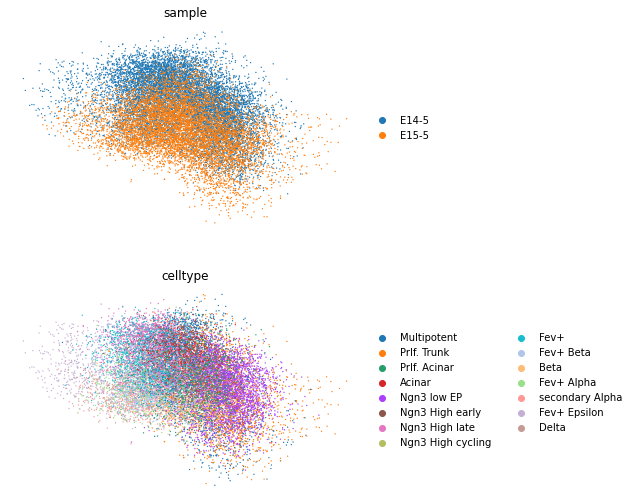

In [56]:
sc.pl.embedding(
    adata,
    basis="X_poiss_vi",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
)

In [57]:
adata

AnnData object with n_obs × n_vars = 16978 × 179427
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'nCount_peaks', 'nFeature_peaks', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'sample', 'ident', 'old_index', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'count', 'percentile', 'n_cells'
    uns: 'X_name', '_scvi_uuid', '_scvi_manager_uuid', 'sample_colors', 'celltype_colors', 'neighbors', 'umap'
    obsm: 'X_poiss_vi', 'X_scVI_pca', 'poiss_vi_X_umap', 'X_poiss_vi_pca'
    layers: 'logcounts', 'ATAC_counts', 'poiss_vi_normalized'
    obsp: 'distances', 'connectivities'

In [58]:
sc.pp.neighbors(adata, use_rep="X_poiss_vi")
sc.tl.umap(adata, key_added="poiss_vi")

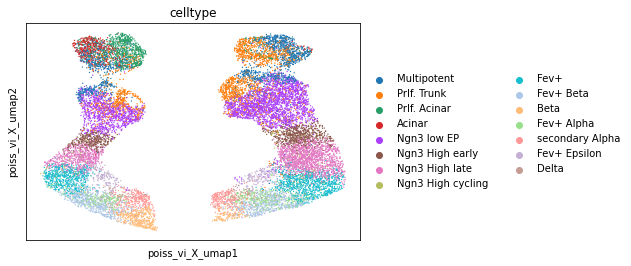

In [59]:
sc.pl.umap(adata, umap_key="poiss_vi_X_umap", color=["celltype"])

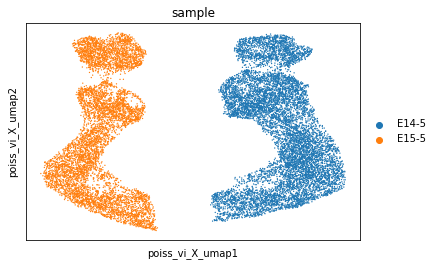

In [51]:
sc.pl.umap(adata, umap_key="poiss_vi_X_umap", color=["sample"])

In [61]:
de_df = poiss_vi.differential_expression(
    groupby="celltype",
)
de_df.head()

DE...: 100%|██████████| 15/15 [51:39<00:00, 206.63s/it]


proba_de  proba_not_de  bayes_factor        scale1  \
13-95023197-95024042     0.9816        0.0184      3.976833  1.533390e-06   
5-56438964-56439852      0.9800        0.0200      3.891820  1.452687e-07   
9-66090936-66091236      0.9764        0.0236      3.722625  2.740171e-06   
17-10109555-10110471     0.9756        0.0244      3.688469  5.370488e-07   
8-111690626-111691550    0.9750        0.0250      3.663561  1.946542e-05   

                             scale2  pseudocounts  delta  lfc_mean  \
13-95023197-95024042   3.926051e-07           0.0   0.25  2.163855   
5-56438964-56439852    2.415647e-06           0.0   0.25 -3.219931   
9-66090936-66091236    1.363966e-06           0.0   0.25  1.756748   
17-10109555-10110471   2.581606e-06           0.0   0.25 -2.082434   
8-111690626-111691550  6.358519e-06           0.0   0.25  3.177331   

                       lfc_median   lfc_std  ...  raw_mean1  raw_mean2  \
13-95023197-95024042     2.330919  3.928411  ...   0.056517   0.016334   
5-56438964-56439852     -3.518159  2.400809  ...   0.002884   0.072422   
9-66090936-66091236      1.941137  5.166149  ...   0.065167   0.035752   
17-10109555-10110471    -2.310454  1.795479  ...   0.020185   0.076030   
8-111690626-111691550    3.747138  2.832111  ...   0.571511   0.213264   

                       non_zeros_proportion1  non_zeros_proportion2  \
13-95023197-95024042                0.027105               0.008659   
5-56438964-56439852                 0.001730               0.034440   
9-66090936-66091236                 0.039216               0.019745   
17-10109555-10110471                0.010381               0.036211   
8-111690626-111691550               0.219723               0.075243   

                       raw_normalized_mean1  raw_normalized_mean2  \
13-95023197-95024042               0.014183              0.004108   
5-56438964-56439852                0.000462              0.023990   
9-66090936-66091236                0.031436              0.012605   
17-10109555-10110471               0.005222              0.024180   
8-111690626-111691550              0.195739              0.063992   

                       is_de_fdr_0.05           comparison       group1 group2  
13-95023197-95024042             True  Multipotent vs Rest  Multipotent   Rest  
5-56438964-56439852              True  Multipotent vs Rest  Multipotent   Rest  
9-66090936-66091236              True  Multipotent vs Rest  Multipotent   Rest  
17-10109555-10110471             True  Multipotent vs Rest  Multipotent   Rest  
8-111690626-111691550            True  Multipotent vs Rest  Multipotent   Rest  

[5 rows x 22 columns]

In [62]:
markers = {}
cats = adata.obs.celltype.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

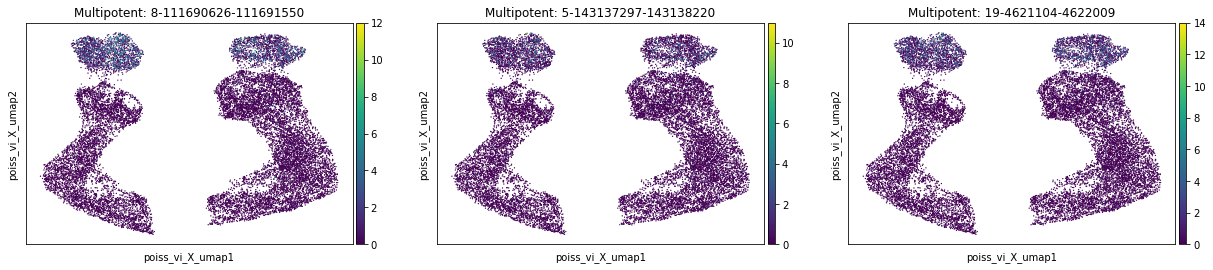

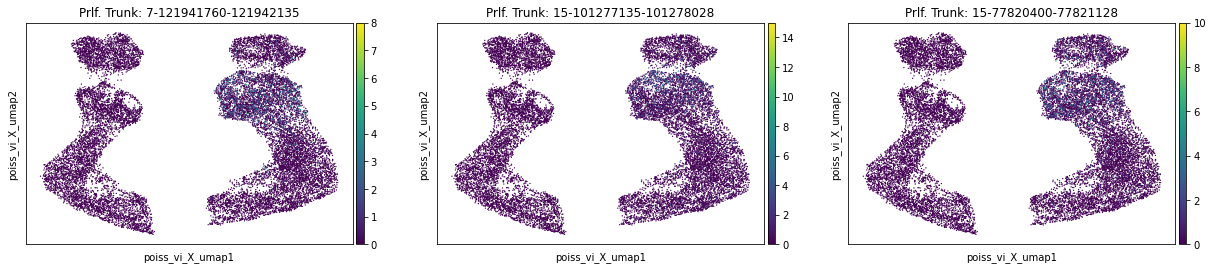

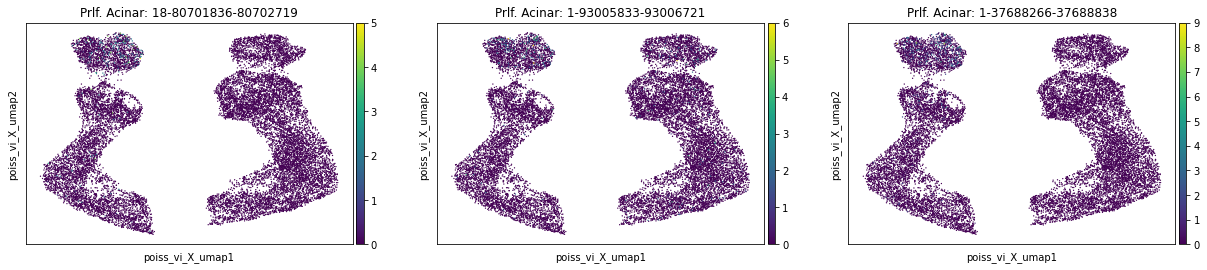

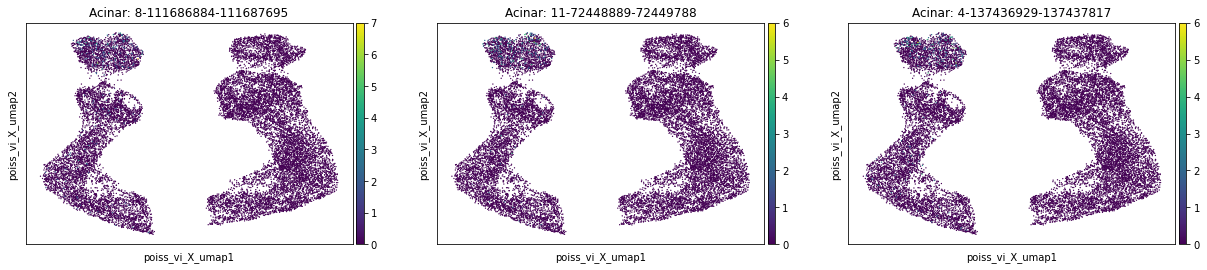

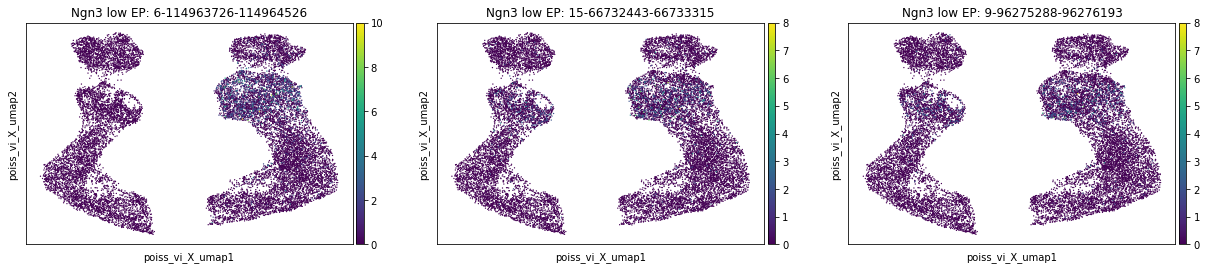

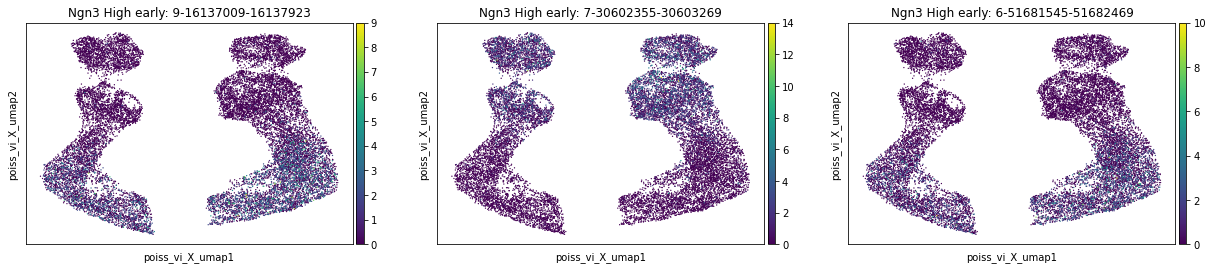

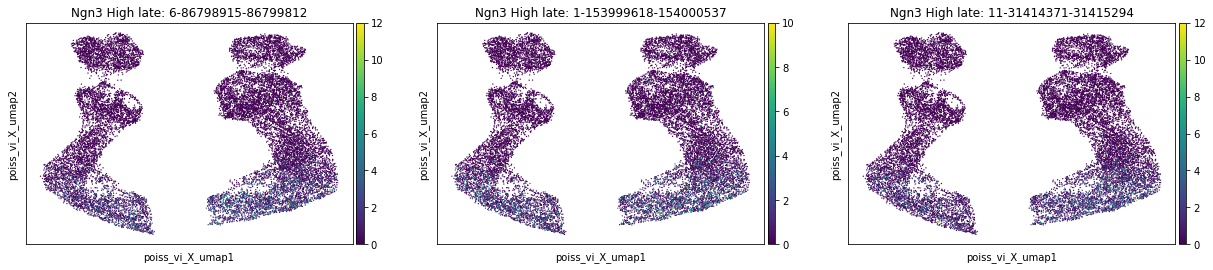

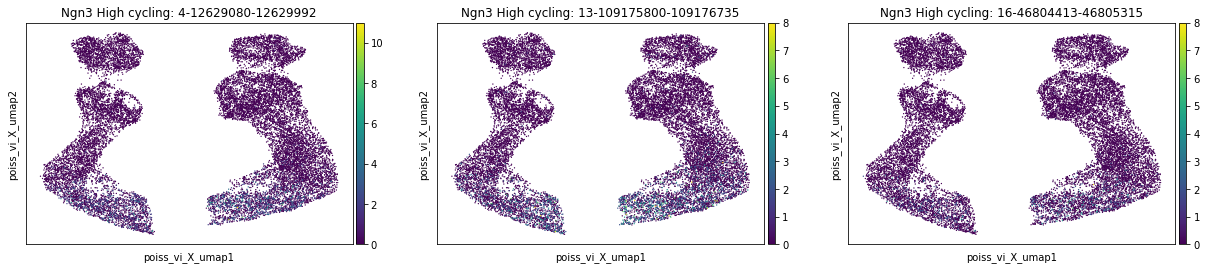

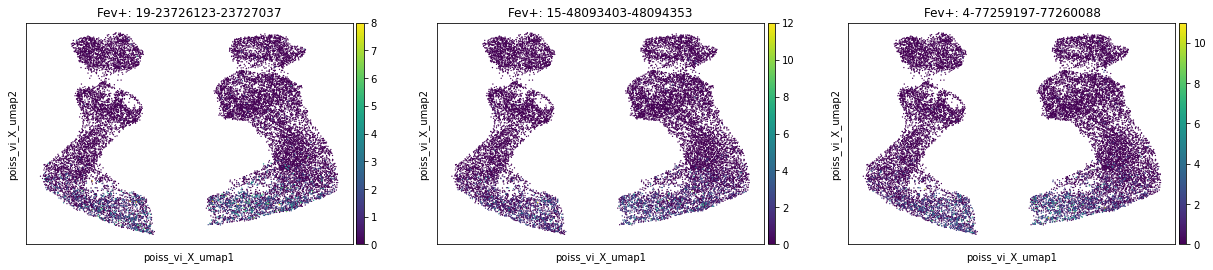

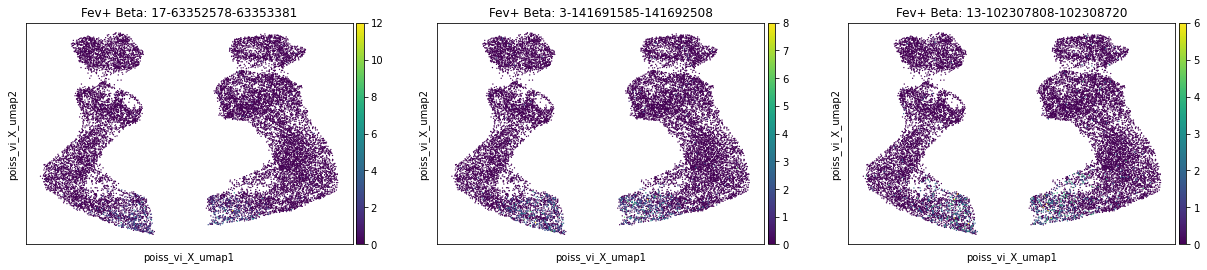

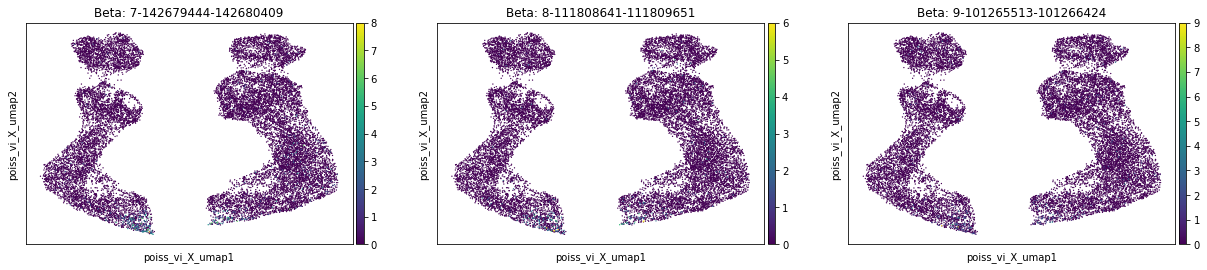

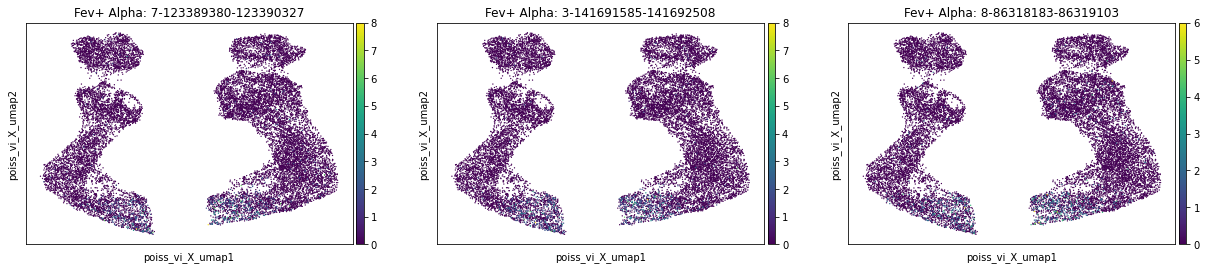

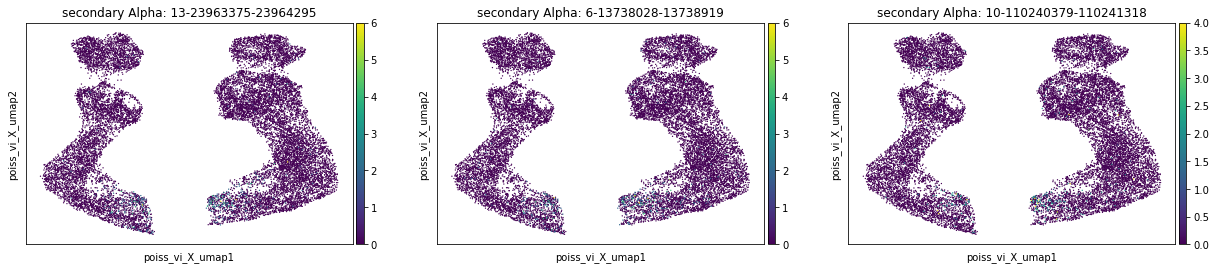

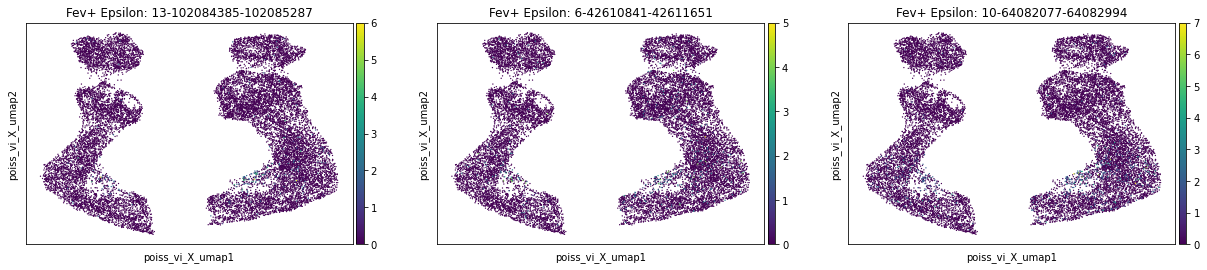

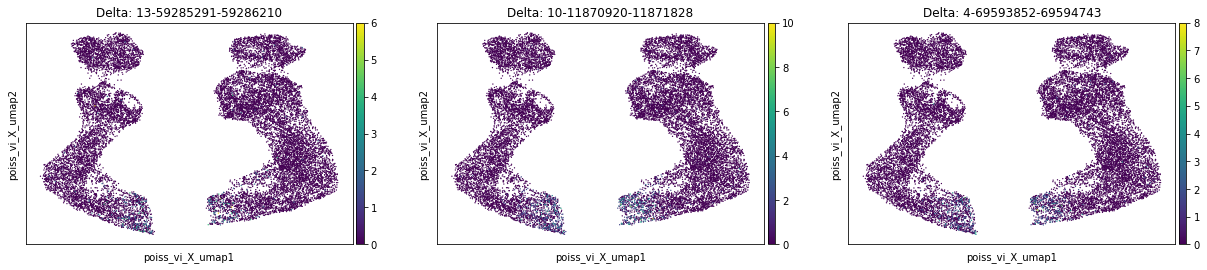

In [63]:
for celltype, marks in markers.items():
    title = [f"{celltype}: {mark}" for mark in marks]
    sc.pl.umap(adata, umap_key="poiss_vi_X_umap", color=marks, title=title)

In [65]:
adata.write("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_poiss_VI_embedding.h5ad")